In [1]:
%matplotlib inline

# Initialisation of Spark environment

In [2]:
import os
if os.environ['SPARK_HOME'] is None:
    # assuming, you installed Spark in your home directory:
    sparkPath = "/home/user/spark-3.0.1-bin-hadoop2.7" #TODO: adjust this
    os.environ['SPARK_HOME'] = sparkPath
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
import re
spark = SparkSession.builder.appName("DataFramesSparkSQL").getOrCreate()
print(spark.version)
sc = spark.sparkContext
sc.setLogLevel("WARN")

3.0.1


In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

# Download the file *'yellow_tripdata_2016-01_10k.csv'* from the OPAL section 'Exercises/Übungen/Data'.
More information about the dataset:
- https://data.cityofnewyork.us/dataset/Yellow-Tripdata-2015-January-June/2yzn-sicd
- http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In [4]:
dataFile = "yellow_tripdata_2016-01_10k.csv"
taxiLineRDD = sc.textFile(dataFile)
print("number of entries: {}".format(taxiLineRDD.count()))

number of entries: 10000


In [5]:
# inspect data
for line in taxiLineRDD.take(3):
    print(line)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990371704101563,40.734695434570313,1,N,-73.981842041015625,40.732406616210937,2,7.5,0.5,0.5,0,0,0.3,8.8
2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980781555175781,40.729911804199219,1,N,-73.944473266601563,40.716678619384766,1,18,0.5,0.5,0,0,0.3,19.3


In [6]:
# obviously, there is a header
header = taxiLineRDD.first()
print('Header is:')
print(header)

Header is:
VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount


In [7]:
# we need to be able to handle date and times...
from datetime import *
from dateutil.parser import parse
print(type(parse("2013-02-09 18:16:10")))  # test it: We should have a datetime object then...

<class 'datetime.datetime'>


# Exercise 1: Measure the time for filtering and collecting. Explain the results.

In [8]:
from time import time
time_before = time()
taxiHeaderRDD = taxiLineRDD.filter(lambda item: "VendorID" in item)
time_after_filter = time()
collectedHeader = taxiHeaderRDD.collect()
time_after_collect = time()
print('taxi header RDD:')
print(collectedHeader)
print('time for filtering:')
print(time_after_filter-time_before)
print('time for collecting:')
print(time_after_collect-time_after_filter)

taxi header RDD:
['VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount']
time for filtering:
0.003462076187133789
time for collecting:
0.10451912879943848


In [9]:
# subtract works on datasets:
taxiDataLineRDD = taxiLineRDD.subtract(taxiHeaderRDD)
# taxiDataLineRDD could be created also directly:
# taxiDataLineRDD = taxiLineRDD.filter(lambda item: "VendorID" not in item)
print(taxiDataLineRDD.count())
print('First line with data:')
print(taxiDataLineRDD.first())

9999
First line with data:
2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550476074219,40.6795654296875,1,N,-73.950271606445313,40.788925170898438,1,33,0.5,0.5,0,0,0.3,34.3


In [10]:
from pyspark.sql import Row

# Exercise 2: Compute transformation and action times.

In [11]:
# how long does it take to compute transformation and action results?
time_before = time()
# convert data types which we use later:
taxiRowRDD = (taxiDataLineRDD.map(lambda item: item.split(","))
                .map(lambda item: Row(ID=item[0], dateA=item[1], dateB=parse(item[2]), passenger=int(item[3]), dist=float(item[4]), fare=item[12], tip=item[15] )
                    ))
time_after_map = time()
firstRow = taxiRowRDD.first()
time_after_first = time()
print('First line as a row:')
print(firstRow)
print('time for mapping:')
print(time_after_map-time_before)
print('time for first:')
print(time_after_first-time_after_map)

First line as a row:
Row(ID='2', dateA='2016-01-01 00:00:00', dateB=datetime.datetime(2016, 1, 1, 0, 0), passenger=1, dist=10.54, fare='33', tip='0')
time for mapping:
0.0001499652862548828
time for first:
0.07567524909973145


# Exercise 3: Create an overview over the data: Show the number of data rows, the types of the columns and a short excerpt of the data.
Hint: Visit the documentation page for DataFrame's pyspark API

https://spark.apache.org/docs/2.4.3/api/python/pyspark.sql.html#pyspark.sql.DataFrame

In [12]:
taxiDF=spark.createDataFrame(taxiRowRDD)
# show number of data rows
print(taxiDF.count())

9999


In [13]:
# show data types
taxiDF.dtypes

[('ID', 'string'),
 ('dateA', 'string'),
 ('dateB', 'timestamp'),
 ('passenger', 'bigint'),
 ('dist', 'double'),
 ('fare', 'string'),
 ('tip', 'string')]

In [14]:
# show a short excerpt
taxiDF.show()

+---+-------------------+-------------------+---------+-----+----+----+
| ID|              dateA|              dateB|passenger| dist|fare| tip|
+---+-------------------+-------------------+---------+-----+----+----+
|  2|2016-01-01 00:00:00|2016-01-01 00:00:00|        1|10.54|  33|   0|
|  2|2016-01-01 00:00:02|2016-01-01 00:11:08|        1| 3.21|11.5|   0|
|  2|2016-01-01 00:00:03|2016-01-01 00:15:49|        6| 2.43|  12|3.99|
|  1|2016-01-01 00:00:05|2016-01-01 00:14:27|        2|  2.2|  11| 1.5|
|  2|2016-01-01 00:00:05|2016-01-01 00:07:17|        1| 0.54|   6|   0|
|  2|2016-01-01 00:00:08|2016-01-01 00:03:24|        1| 0.69| 4.5|   0|
|  1|2016-01-01 00:00:09|2016-01-01 00:19:03|        3|  5.3|  18|3.85|
|  2|2016-01-01 00:00:10|2016-01-01 00:02:20|        1| 0.87| 4.5|   0|
|  2|2016-01-01 00:00:12|2016-01-01 00:01:17|        1| 0.13|   3|   0|
|  1|2016-01-01 00:00:17|2016-01-01 00:13:59|        1|  1.5|  10|3.35|
|  1|2016-01-01 00:00:21|2016-01-01 00:17:30|        1|  0.7|  1

# Grouping

In [15]:
# using groupBy
taxiDF.groupBy("ID").count().show()

+---+-----+
| ID|count|
+---+-----+
|  1| 4354|
|  2| 5645|
+---+-----+



In [16]:
# equivalent method with an SQL query
# Create a temporary view from the DataFrame
taxiDF.registerTempTable("taxi")
sqlContext.sql("SELECT ID, COUNT(*) FROM taxi GROUP BY ID").show()

+---+--------+
| ID|count(1)|
+---+--------+
|  1|    4354|
|  2|    5645|
+---+--------+



# Exercise 4: Count trips grouped by passengers. Find the minimal distance as well.

In [17]:
taxiDF.groupBy("passenger").count().show()

+---------+-----+
|passenger|count|
+---------+-----+
|        6|  351|
|        5|  605|
|        1| 6602|
|        3|  539|
|        2| 1631|
|        4|  271|
+---------+-----+



In [18]:
taxiDF.groupBy("passenger").min("dist").show()

+---------+---------+
|passenger|min(dist)|
+---------+---------+
|        6|     0.25|
|        5|      0.0|
|        1|      0.0|
|        3|      0.0|
|        2|      0.0|
|        4|     0.01|
+---------+---------+



**Query**

In [19]:
# Apply a SQL query
query = "SELECT fare FROM taxi WHERE dist>=5"
sqlContext.sql(query).show()

+----+
|fare|
+----+
|  33|
|  18|
|24.5|
|17.5|
|  44|
|40.5|
|20.5|
|  17|
|22.5|
|  18|
|  52|
|23.5|
|29.5|
|26.5|
|  22|
|  26|
| 126|
|32.5|
|  37|
|  31|
+----+
only showing top 20 rows



# Exercise 5: Rewrite the previous statement without SQL, but with a functional statement.

In [20]:
taxiDF.filter(taxiDF.dist>5).select("fare").show()

+----+
|fare|
+----+
|  33|
|  18|
|24.5|
|17.5|
|  44|
|40.5|
|20.5|
|  17|
|22.5|
|  18|
|  52|
|23.5|
|29.5|
|26.5|
|  22|
|  26|
| 126|
|32.5|
|  37|
|  31|
+----+
only showing top 20 rows



In [21]:
#compute summary statistics
taxiDF.describe().show()

+-------+-------------------+-------------------+------------------+------------------+------------------+-----------------+
|summary|                 ID|              dateA|         passenger|              dist|              fare|              tip|
+-------+-------------------+-------------------+------------------+------------------+------------------+-----------------+
|  count|               9999|               9999|              9999|              9999|              9999|             9999|
|   mean| 1.5645564556455644|               null|1.7697769776977699|  3.06995699569957|11.937063706370637|1.504447444744474|
| stddev|0.49583974447246415|               null| 1.369663409687648|3.3514113414719424| 9.643450090344786|2.349804623488286|
|    min|                  1|2016-01-01 00:00:00|                 1|               0.0|              -2.5|                0|
|    max|                  2|2016-01-29 09:20:52|                 6|             47.39|               9.8|             9.85|


# Exercise 6: Find the distance for tips larger than $5  - Formulate a SQL query and apply it on the DataFrame.

In [22]:
query = "SELECT dist FROM taxi WHERE tip>=5"
sqlContext.sql(query).show()

+-----+
| dist|
+-----+
| 7.04|
|19.22|
| 6.82|
|  6.1|
|  7.9|
| 10.0|
|13.27|
| 9.46|
|  5.3|
| 8.35|
|  7.7|
|12.94|
|21.36|
| 5.23|
|14.84|
|13.28|
| 13.0|
| 14.0|
| 8.35|
| 10.5|
+-----+
only showing top 20 rows



# Exercise 7: Include the total cost into the DataFrame and build a new DataFrame object. Afterwards select all tips for distances > 30miles

In [23]:
taxiWithTotalRowRDD = (taxiDataLineRDD.map(lambda item: item.split(","))
                .map(lambda item: Row(ID=item[0], dateA=item[1], dateB=parse(item[2]), passenger=int(item[3]), dist=float(item[4]), fare=item[12], tip=item[15], total=item[18] )
                    ))
taxiWithTotalDF = spark.createDataFrame(taxiWithTotalRowRDD)
print('after mapping transformation number of elements>')
print(taxiWithTotalRowRDD.first())
taxiWithTotalDF.filter(taxiWithTotalDF.dist > 30).collect()

after mapping transformation number of elements>
Row(ID='2', dateA='2016-01-01 00:00:00', dateB=datetime.datetime(2016, 1, 1, 0, 0), passenger=1, dist=10.54, fare='33', tip='0', total='34.3')


[Row(ID='1', dateA='2016-01-29 09:19:45', dateB=datetime.datetime(2016, 1, 29, 10, 18, 31), passenger=3, dist=42.0, fare='126', tip='0.01', total='142.35'),
 Row(ID='2', dateA='2016-01-02 01:04:23', dateB=datetime.datetime(2016, 1, 2, 2, 0, 52), passenger=1, dist=47.39, fare='139', tip='30.18', total='181.06'),
 Row(ID='1', dateA='2016-01-02 01:29:33', dateB=datetime.datetime(2016, 1, 2, 2, 28, 3), passenger=1, dist=45.5, fare='150', tip='0', total='176.3')]

# Exercise 8: Count the number of entries to verify the input and show the content.

In [24]:
print(taxiWithTotalDF.count())
taxiWithTotalDF.show()

9999
+---+-------------------+-------------------+---------+-----+----+----+-----+
| ID|              dateA|              dateB|passenger| dist|fare| tip|total|
+---+-------------------+-------------------+---------+-----+----+----+-----+
|  2|2016-01-01 00:00:00|2016-01-01 00:00:00|        1|10.54|  33|   0| 34.3|
|  2|2016-01-01 00:00:02|2016-01-01 00:11:08|        1| 3.21|11.5|   0| 12.8|
|  2|2016-01-01 00:00:03|2016-01-01 00:15:49|        6| 2.43|  12|3.99|17.29|
|  1|2016-01-01 00:00:05|2016-01-01 00:14:27|        2|  2.2|  11| 1.5| 13.8|
|  2|2016-01-01 00:00:05|2016-01-01 00:07:17|        1| 0.54|   6|   0|  7.3|
|  2|2016-01-01 00:00:08|2016-01-01 00:03:24|        1| 0.69| 4.5|   0|  5.8|
|  1|2016-01-01 00:00:09|2016-01-01 00:19:03|        3|  5.3|  18|3.85|23.15|
|  2|2016-01-01 00:00:10|2016-01-01 00:02:20|        1| 0.87| 4.5|   0|  5.8|
|  2|2016-01-01 00:00:12|2016-01-01 00:01:17|        1| 0.13|   3|   0|  4.3|
|  1|2016-01-01 00:00:17|2016-01-01 00:13:59|        1|  1.

# Exercise 9: Formulate a query to get total amount of trip for distances larger than 30 miles.

In [25]:
taxiWithTotalDF.registerTempTable("taxiWithTotal")
query = "SELECT SUM(total) FROM taxiWithTotal WHERE dist>=30"
sqlContext.sql(query).show()

+--------------------------+
|sum(CAST(total AS DOUBLE))|
+--------------------------+
|                    499.71|
+--------------------------+



# Exercise 10: Create a box-and-whisker plot of the numerical columns. What do these say about the data?

In [26]:
import matplotlib.pyplot as plt

In [27]:
help(taxiDF)

Help on DataFrame in module pyspark.sql.dataframe object:

class DataFrame(pyspark.sql.pandas.map_ops.PandasMapOpsMixin, pyspark.sql.pandas.conversion.PandasConversionMixin)
 |  A distributed collection of data grouped into named columns.
 |  
 |  A :class:`DataFrame` is equivalent to a relational table in Spark SQL,
 |  and can be created using various functions in :class:`SparkSession`::
 |  
 |      people = spark.read.parquet("...")
 |  
 |  Once created, it can be manipulated using the various domain-specific-language
 |  (DSL) functions defined in: :class:`DataFrame`, :class:`Column`.
 |  
 |  To select a column from the :class:`DataFrame`, use the apply method::
 |  
 |      ageCol = people.age
 |  
 |  A more concrete example::
 |  
 |      # To create DataFrame using SparkSession
 |      people = spark.read.parquet("...")
 |      department = spark.read.parquet("...")
 |  
 |      people.filter(people.age > 30).join(department, people.deptId == department.id) \
 |        .grou

passenger quantiles: [1.0, 1.0, 1.0, 2.0, 6.0]
dist quantiles: [0.0, 1.1, 1.9, 3.7, 47.39]


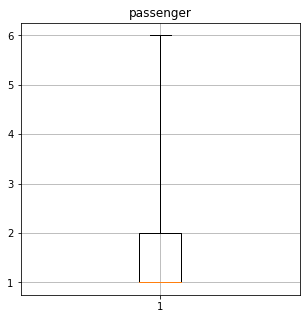

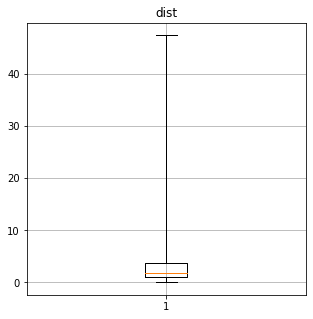

In [28]:
for column in taxiDF.dtypes:
    name = column[0]
    colType = column[1]
    if colType != 'string' and colType != 'timestamp':
        columnQuantiles = taxiDF.approxQuantile(col=name,probabilities=[0.0,0.25,0.50,0.75,1.00],relativeError=0.01)
        print("{} quantiles: {}".format(name,columnQuantiles))
        stats = [{
            "whislo": columnQuantiles[0],
            "q1": columnQuantiles[1],
            "med": columnQuantiles[2],
            "q3": columnQuantiles[3],
            "whishi": columnQuantiles[4]
        }]
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharey=True)
        axes.bxp(bxpstats=stats, showfliers=False)
        axes.grid(True)
        axes.set_title(name)

# Exercise 11: Provide an overview over the number of trips per week day.

In [29]:
def barchart(dataRows, titleSuffix):
    positions = list(reversed(range(len(dataRows))))
    names = [str(item[titleSuffix]) + " (" + str(item['count']) + ")" for item in dataRows]
    values = [item['count'] for item in dataRows]
    plt.grid()
    plt.barh(positions,values,align="center")
    plt.yticks(positions,names)
    plt.xlabel("Number of trips")
    plt.title("Distribution of trips per " + titleSuffix)
    plt.show()

In [30]:
help(datetime.weekday)

Help on method_descriptor:

weekday(...)
    Return the day of the week represented by the date.
    Monday == 0 ... Sunday == 6



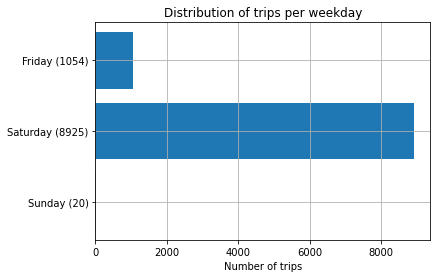

In [31]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
import calendar

#udf stands for user defined function
@udf 
def weekdayStr(d):
    return calendar.day_name[d.weekday()]

@udf(returnType=IntegerType())
def weekday(d):
    return d.weekday()

weekdayRows = taxiDF.select(weekdayStr(taxiDF.dateB).alias("weekday")).groupBy("weekday").count().collect()

barchart(weekdayRows, "weekday")

# Exercise 12: Provide an overview over the number of trips per hour.

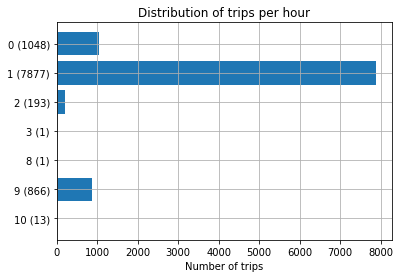

In [32]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

@udf(returnType=IntegerType())
def hour(d):
    return d.hour

hourRows = sorted(taxiDF.select(hour(taxiDF.dateB).alias("hour")).groupBy("hour").count().collect())

barchart(hourRows, "hour")

In [33]:
sc.stop()